In [1]:
!pip install 'gluonts[torch]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.7 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.2.2
    Uninstalling pytorch-lightning-2.2.2:
      Successfully uninstalled pytorch-lightning-2.2.2


In [19]:
import pandas as pd
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.torch.distributions import NormalOutput
from gluonts.evaluation import make_evaluation_predictions
import matplotlib.pyplot as plt
import json


path = '../input/tourism-data/'
# Split train and test
df = pd.read_csv(path+'Tourism_process_for_deepar.csv')
df.set_index('Date',inplace=True)
#df.index = pd.to_datetime(df.index).dt.strftime('%Y-%m-%d %H:%M:%S')
prediction_length = 12
freq = 'MS'
split_date = pd.to_datetime('2016-01-01').strftime('%Y-%m-%d %H:%M:%S')
train = df[df.index < split_date]
test = df[df.index >= split_date]

train.reset_index(inplace=True)
test.reset_index(inplace=True)

train1 = train.drop_duplicates(subset=['Node','Region','Zone','State'])
train_static = pd.DataFrame({'State':train1['State'],
                             'Zone':train1['Zone'],
                             'Region':train1['Region'],
                             'Node':train1['Node']})
train_static.set_index('Node',inplace=True)

train_group = train.groupby('Node')
standardized_params = {}
train_standard = train.copy()

# 标准化
for cat,group in train_group:
    train_group = train.groupby('Node')
    means = group['Value'].mean()
    stds = group['Value'].std()
    standardized_params[cat] = {'mean':means,'std':stds}

    train_standard.loc[group.index,'Value'] = (group['Value']-means)/stds

#min-max
# for cat,group in train_group:
#     train_group = train.groupby('Node')
#     maxs = group['Value'].max()
#     mins = group['Value'].min()
#     standardized_params[cat] = {'max':maxs,'min':mins}

#     train_standard.loc[group.index,'Value'] = (group['Value']-mins)/(maxs-mins)



In [20]:
standardized_params

{'A': {'mean': 7594.029486609722, 'std': 2558.168405934819},
 'AA': {'mean': 2224.516472201389, 'std': 617.901510968573},
 'AAA': {'mean': 1909.7316513129629, 'std': 456.72320582557984},
 'AAB': {'mean': 314.7848208884259, 'std': 205.78679043786937},
 'AB': {'mean': 2111.037905529167, 'std': 928.6806283963281},
 'ABA': {'mean': 656.9129731638889, 'std': 248.1958496139447},
 'ABB': {'mean': 1454.1249323652778, 'std': 715.9369960421126},
 'AC': {'mean': 965.0174023050926, 'std': 696.5884276966929},
 'ACA': {'mean': 965.0174023050926, 'std': 696.5884276966929},
 'AD': {'mean': 837.8560778796295, 'std': 261.09724914041965},
 'ADA': {'mean': 213.5064910787037, 'std': 161.2532835529646},
 'ADB': {'mean': 193.58937917731478, 'std': 76.33904051278138},
 'ADC': {'mean': 246.21495807824073, 'std': 111.3341917773212},
 'ADD': {'mean': 184.54524954537035, 'std': 86.18736759295668},
 'AE': {'mean': 994.9299132722222, 'std': 296.6852704415932},
 'AEA': {'mean': 413.9555707898148, 'std': 148.20372320

In [21]:
train_ds = PandasDataset.from_long_dataframe(train_standard.iloc[:,[0,1,2,3]],
                                             target="Value",
                                             timestamp='Date',
                                             freq='M',
                                             item_id="Node",
                                             feat_dynamic_real=["Month_Of_Year"],
                                             static_features=train_static)

# Estimator
estimator = DeepAREstimator(freq=freq,
                            prediction_length=prediction_length,
                            context_length=10*prediction_length,
                            num_layers=3,
                            hidden_size=41,
                            lr=1e-2,
                            weight_decay=1e-8,
                            dropout_rate=0.1,
                            num_feat_dynamic_real=1,
                            num_feat_static_real=3,
                            distr_output=NormalOutput(),
                            scaling=False,
                            num_parallel_samples=1000,
                            patience=10,
                            batch_size=16,
                            trainer_kwargs={'accelerator':'gpu','max_epochs':300})

In [22]:
# train
import time

st = time.time()
# Train
predictor = estimator.train(train_ds,num_workers=4)

et = time.time()
print(et-st)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | In sizes                                                      | Out sizes    
----------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 38.6 K | [[1, 1], [1, 3], [1, 156, 3], [1, 156], [1, 156], [1, 12, 3]] | [1, 1000, 12]
----------------------------------------------------------------------------------------------------------------------
38.6 K    Trainable params
0         Non-trainable params
38.6 K    Total params
0.154     Total estimated model params size (M

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.96696 (best 0.96696), saving model to '/kaggle/working/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.83305 (best 0.83305), saving model to '/kaggle/working/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 0.81543 (best 0.81543), saving model to '/kaggle/working/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO: Epoch 3, global step 200: 'train_loss' reached 0.78704 (best 0.78704), saving model to '/kaggle/working/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO: Epoch 4, global step 250: 'train_loss' reached 0.78282 (best 0.78282), saving model to '/kaggle/working/lightning_logs/version_2/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO: Epoch 5, global step 300: 'train_loss' reached 0.77838 (best 0.77838), saving model to '/kaggle/worki

468.67764019966125


In [ ]:
ls ./lightning_logs/version_1/checkpoints/

In [ ]:
# train for 200 epoch
import time
estimator = DeepAREstimator(freq=freq,
                            prediction_length=prediction_length,
                            context_length=10*prediction_length,
                            num_layers=3,
                            hidden_size=41,
                            lr=1e-2,
                            weight_decay=1e-8,
                            dropout_rate=0.1,
                            num_feat_dynamic_real=1,
                            num_feat_static_real=3,
                            distr_output=NormalOutput(),
                            scaling=False,
                            num_parallel_samples=1000,
                            batch_size=16,
                            trainer_kwargs={'accelerator':'gpu','max_epochs':300})
st = time.time()
# Train
predictor = estimator.train(train_ds,ckpt_path='./lightning_logs/version_1/checkpoints/epoch=195-step=9800.ckpt',num_workers=4)

et = time.time()
print(et-st)

AEC
BD
D


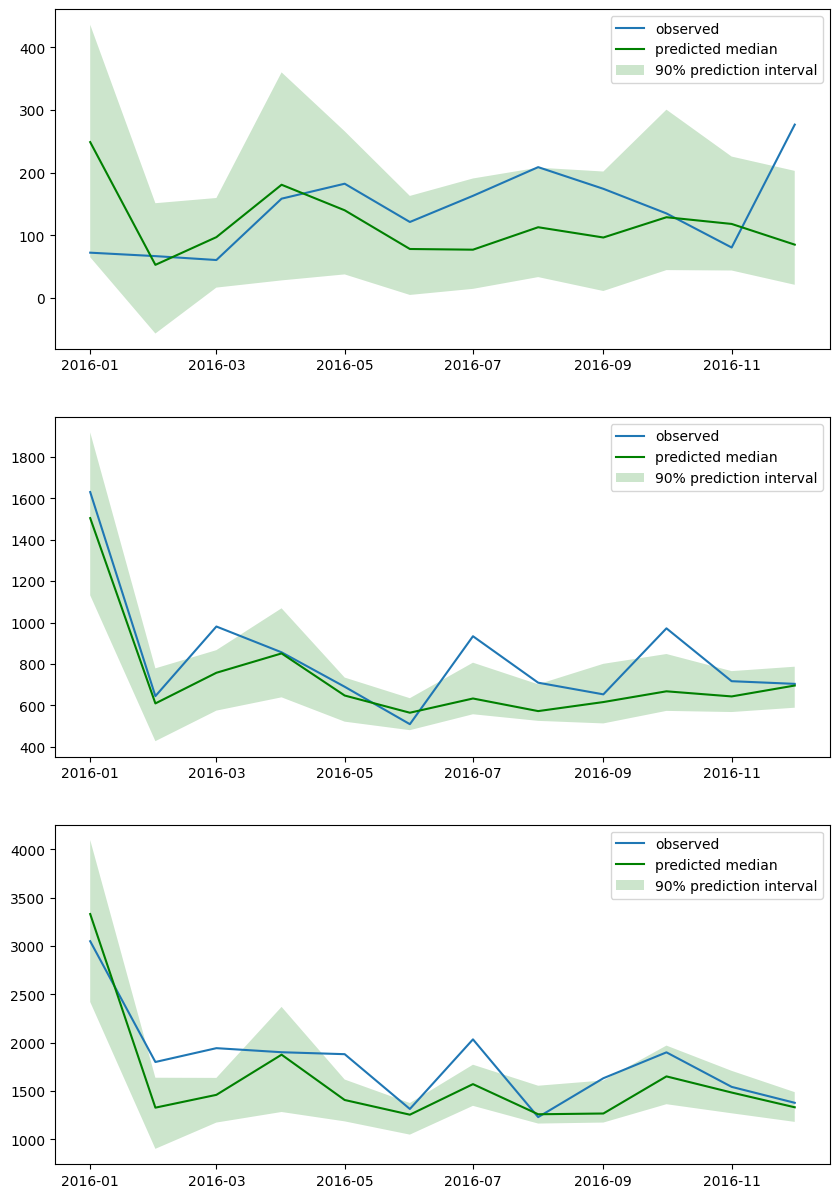

In [23]:
# Evaluation
test1 = test.drop_duplicates(subset=['Node','Region','Zone','State'])
test_static = pd.DataFrame({'State':test1['State'],
                             'Zone':test1['Zone'],
                             'Region':test1['Region'],
                             'Node':test1['Node']})
test_static.set_index('Node',inplace=True)

test_ds = PandasDataset.from_long_dataframe(test.iloc[:,[0,1,2,3]],
                                             target="Value",
                                             item_id="Node",
                                             feat_dynamic_real=["Month_Of_Year"],
                                             static_features=test_static,
                                             timestamp='Date',
                                             freq='M')
forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor,num_samples=1000)
forecasts = list(forecast_it)
tests = list(ts_it)

# Anti standardized
# 标准化
f_cp = forecasts
for index in range(len(forecasts)):
    index_mean = standardized_params[forecasts[index].item_id]['mean']
    index_std = standardized_params[forecasts[index].item_id]['std']
    f_cp[index].samples = (forecasts[index].samples)*index_std+index_mean

# min-max
# f_cp = forecasts
# for index in range(len(forecasts)):
#     index_max = standardized_params[forecasts[index].item_id]['max']
#     index_min = standardized_params[forecasts[index].item_id]['min']
#     f_cp[index].samples = (forecasts[index].samples)*(index_max-index_min)+index_min

# Plot
n_plot = 3
indices = np.random.choice(np.arange(0, 111), size=n_plot, replace=False)
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
for index, ax in zip(indices, axes):
    ax.plot(tests[index].to_timestamp())
    plt.sca(ax)
    print(f_cp[index].item_id)
    f_cp[index].plot(intervals=(0.9,), color="g")
    plt.legend(["observed", "predicted median", "90% prediction interval"])

# sort
node_nonsort = []
new_df = pd.read_csv(path+'Tourism_process.csv')
node_list = new_df.columns[2:]
for i in range(len(forecasts)):
    node_nonsort.append(forecasts[i].item_id)
index_list = [node_nonsort.index(i) for i in node_list]

# Save the distri params
distr_params = []
for j in range(12):
    params_mean = []
    params_var = []
    for i in range(len(forecasts)):
        params_mean.append(float(np.mean(forecasts[i].samples[:,j])))
        params_var.append(float(np.var(forecasts[i].samples[:,j],ddof=1)))
    distr_params.append([params_mean,params_var])

distr_params_new = distr_params
for j in range(12):
    distr_params_new[j][0] = [distr_params[j][0][i] for i in index_list]
    distr_params_new[j][1] = [distr_params[j][1][i] for i in index_list]
    


In [ ]:
plt.savefig('./pic.png')

In [24]:
with open('Tourism_deepar_e300_optuna.json','w') as file:
    file.write(json.dumps(distr_params_new))

In [25]:
!cat ./Tourism_deepar_e300_optuna.json

[[[43442.89453125, 15774.0380859375, 10149.6533203125, 10988.318359375, 3308.36279296875, 3624.741455078125, 1207.2354736328125, 870.5288696289062, 4152.60888671875, 5003.24169921875, 3111.733154296875, 1638.351806640625, 1922.6907958984375, 876.1378784179688, 4448.4970703125, 1462.9625244140625, 1776.571044921875, 1512.7977294921875, 1298.251953125, 5334.96435546875, 1447.9132080078125, 1813.619384765625, 841.0147705078125, 1031.3966064453125, 569.6647338867188, 497.0704345703125, 432.1331787109375, 2395.799560546875, 705.3336181640625, 363.47882080078125, 529.5789794921875, 400.6157531738281, 248.32049560546875, 572.4608764648438, 242.40174865722656, 3320.79296875, 956.0516967773438, 1431.8695068359375, 3670.013916015625, 3060.425537109375, 518.121826171875, 298.7325134277344, 394.5610656738281, 295.214599609375, 614.1964111328125, 494.7734375, 250.82069396972656, 209.6739044189453, 643.0032348632812, 2249.742431640625, 848.9896850585938, 518.5208129882812, 1050.3055419921875, 416.80